In [1]:
import numpy as np
import mne
from mne import preprocessing

from scipy import signal
from tfld import utils, tfld

import matplotlib.pyplot as plt

# from libci import utils

import pyxdf

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import pandas as pd

from sklearn.decomposition import PCA
from joblib import delayed, Parallel

%load_ext autoreload
%autoreload 2

In [ ]:
def bootstrap_projection_vectors(X, y, number_of_bootstraps, eps=0):
    n, d = X.shape

    bootstrap_vectors = np.zeros((number_of_bootstraps, d))
    
    unique, counts = np.unique(y, return_counts=True)
        
    for i in range(number_of_bootstraps):        
        bootstrap_inds = np.hstack([np.random.choice(np.where(y == j)[0], size=c, replace=True) for j,c in zip(unique, counts)])
        
        if eps == 0:
            pert = np.zeros(X[bootstrap_inds].shape)
        else:
            pert = np.random.normal(0, eps, size=X[bootstrap_inds].shape)
        
        fld = FLD().fit(X[bootstrap_inds]+pert, y[bootstrap_inds])
        bootstrap_vectors[i] = fld.projection_
        
    return bootstrap_vectors

In [2]:
dir_ = '/home/azureuser/physionet.org/files/eegmat/1.0.0/'

meta = pd.read_csv(dir_ + 'subject-info.csv')
meta.head()

,Subject,Age,Gender,Recording year,Number of subtractions,Count quality
0,Subject00,21,F,2011,9.70,0
1,Subject01,18,F,2011,29.35,1
2,Subject02,19,F,2012,12.88,1
3,Subject03,17,F,2010,31.00,1
4,Subject04,17,F,2010,8.60,0


In [3]:
subject_labels = np.array(list(meta['Count quality']))
gender = np.array(list(meta['Gender']))
recording_year = np.array(list(meta['Recording year']))

raw_edfs = utils.get_raw_edfs(dir_)

raw_edfs = [r.drop_channels(['ECG ECG', 'EEG A2-A1']) for r in raw_edfs]
raw_edfs = [r.rename_channels(lambda x: x.split(' ')[-1]) for r in raw_edfs]
    
montage = mne.channels.make_standard_montage(kind='standard_1020')

infos = [r.set_montage(montage, on_missing='ignore') for r in raw_edfs]
infos = [r.load_data().set_eeg_reference(ref_channels='average') for r in infos]
infos = [r.filter(0.5, 30) for r in infos]

channel_names = infos[0].ch_names
print(channel_names)

Reading 0 ... 90999  =      0.000 ...   181.998 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Reading 0 ... 30999  =      0.000 ...    61.998 secs..

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 3301 samples (6.602 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband e

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 3301 samples (6.602 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband e

[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 3301 samples (6.602 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband e

[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 3301 samples (6.602 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband e

[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 3301 samples (6.602 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband e

[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 3301 samples (6.602 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband e

[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 3301 samples (6.602 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband e

[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 3301 samples (6.602 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband e

[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 3301 samples (6.602 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband e

[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 3301 samples (6.602 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband e

[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 3301 samples (6.602 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband e

[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 3301 samples (6.602 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband e

[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 3301 samples (6.602 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband e

[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 3301 samples (6.602 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband e

[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 3301 samples (6.602 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband e

[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 3301 samples (6.602 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband e

[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 3301 samples (6.602 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband e

[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 3301 samples (6.602 sec)

['Fp1', 'Fp2', 'F3', 'F4', 'F7', 'F8', 'T3', 'T4', 'C3', 'C4', 'T5', 'T6', 'P3', 'P4', 'O1', 'O2', 'Fz', 'Cz', 'Pz']


[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.0s finished


In [5]:
np.random.seed(1)

# channel_inds = np.array([0,1,2,3,4,5])
# channel_inds = np.array([0,1,4,6,7,11,14,18])
channel_inds = np.arange(len(channel_names))
sfreq=500

nspw=1
windowed = utils.get_time_windows([r.get_data()[channel_inds] for r in infos], sfreq=sfreq, n_seconds_per_window=nspw, n_seconds_overlap=0)

bands = [[4,8], [8,12], [12,20]]
psd = utils.get_power_spectrum_ratio(windowed, sfreq, bands)
psd = [p / np.sum(p, axis=-1, keepdims=True) for p in psd]

concat = utils.concatenate_features(psd, axes=[-2,-1])

X = [np.concatenate((concat[i], concat[i+1])) for i in range(0, len(concat), 2)]
y = [np.concatenate((i * np.ones(concat[i].shape[0]), (i+1) * np.ones(concat[i+1].shape[0]))) for i in range(0, len(concat), 2)]
y = [t.astype(int) % 2 for t in y]

/home/azureuser/FLD_optimal_weighting/tfld/tfld.py:103: RuntimeWarning: invalid value encountered in true_divide
  self.projection_ /= np.linalg.norm(self.projection_)
/home/azureuser/FLD_optimal_weighting/tfld/tfld.py:103: RuntimeWarning: invalid value encountered in true_divide
  self.projection_ /= np.linalg.norm(self.projection_)


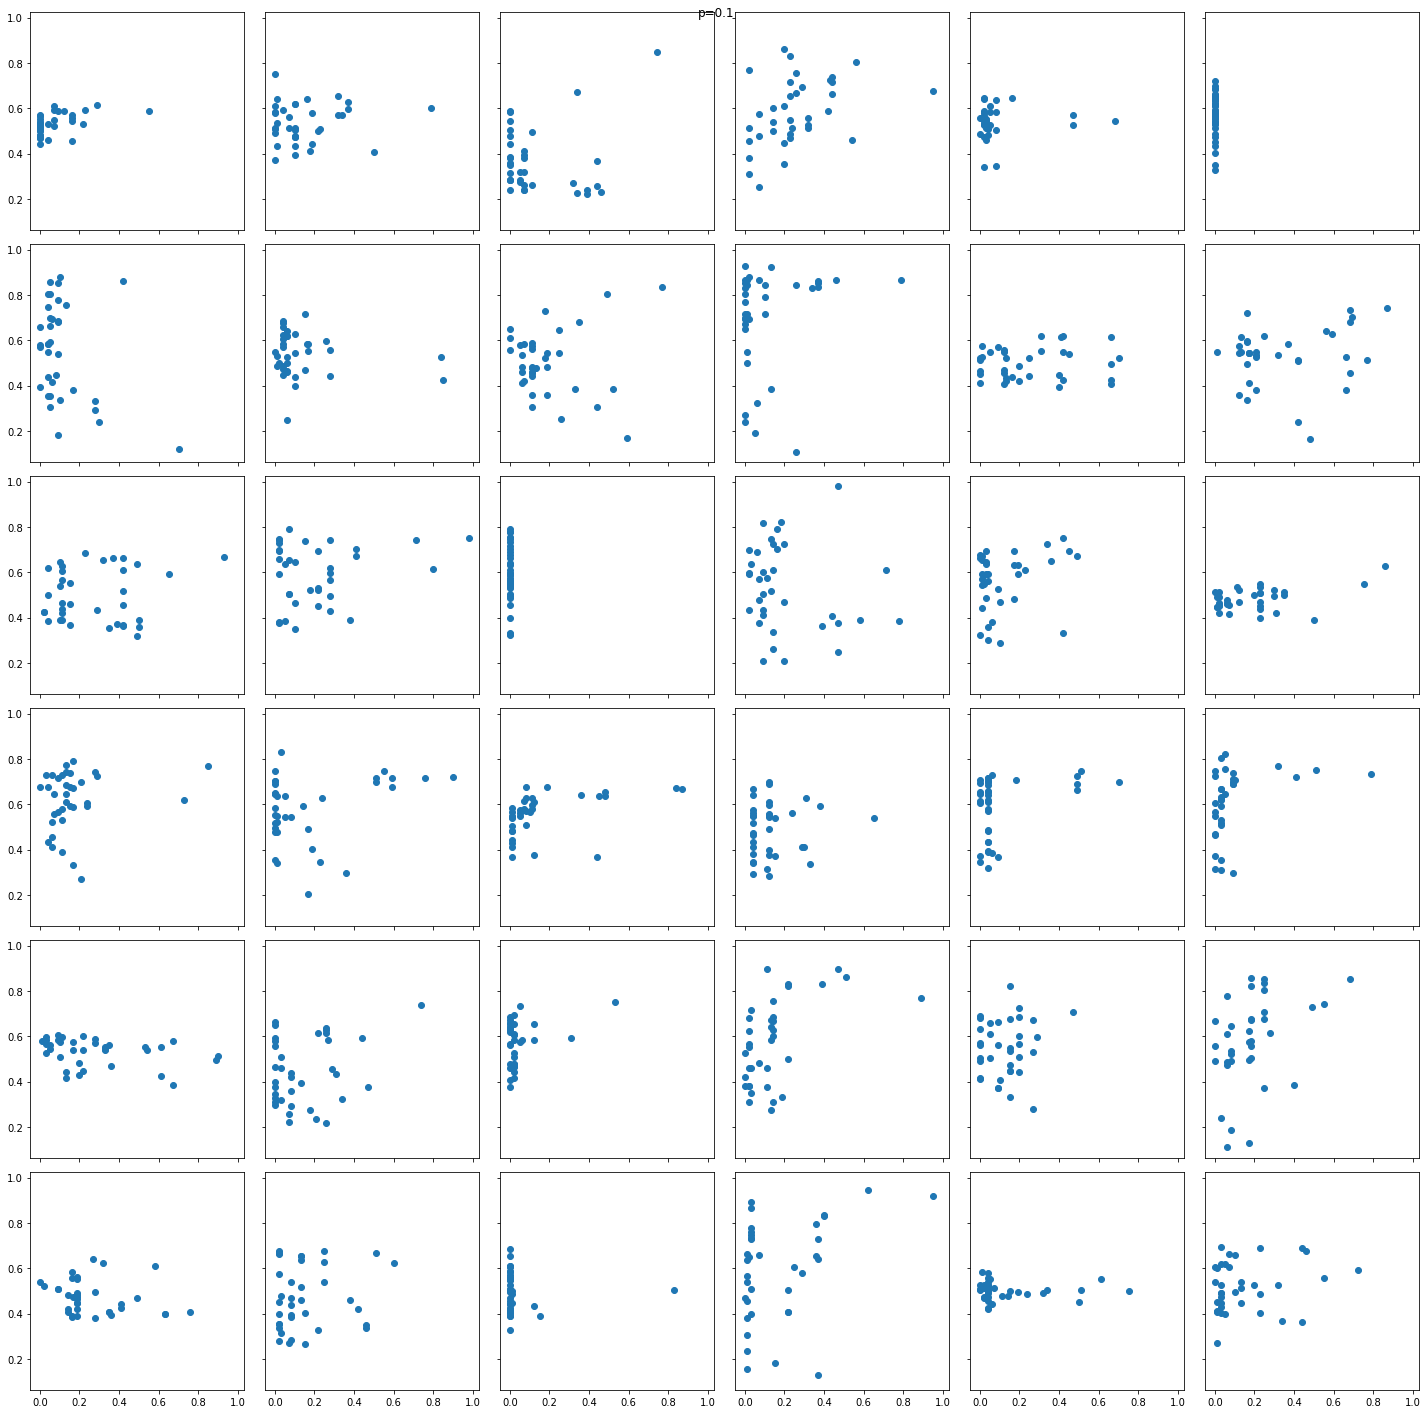

In [302]:
# make target task projection vectors == [+/-1, 0_{d-1}]
from tfld import tfld
from itertools import combinations
from math import comb

metric= abs_cosine_dist

n_tasks = len(X)

scalers = [tfld.TranslateStandardScale().fit(X[i], y[i]) for i in range(n_tasks)]

flds = [tfld.FLD(zero_intersection=True).fit(scalers[i].transform(X[i]), y[i]) for i in range(n_tasks)]

projections = [fld.projection_ for fld in flds]
covs = [fld.cov for fld in flds]

fig, ax = plt.subplots(6,6, figsize=(20,20), sharey=True, sharex=True)

p=0.1
for index in range(n_tasks):
    train_inds = tfld.even_sample_inds(y[index], p=p)
    scaler = tfld.TranslateStandardScale().fit(X[index][train_inds], y[index][train_inds])
    X_ = scaler.transform(X[index])

    fld = tfld.FLD().fit(X_[train_inds], y[index][train_inds])

    in_task_proj = fld.projection_
    dir_vectors = [in_task_proj] + [p for j,p in enumerate(projections) if j != index]
    
    bootstrap_vectors = bootstrap_projection_vectors(X_[train_inds], y[index][train_inds], 100, eps=0)
    
    mean_bootstrap=np.mean(bootstrap_vectors, axis=0)
    mean_bootstrap/=np.linalg.norm(mean_bootstrap)
    average_differences = get_pairwise_metric(bootstrap_vectors, abs_cosine_dist)
    
    test_statistics = np.array([ metric(mean_bootstrap, v) for v in dir_vectors ])
    p_values = np.array([np.mean(t <= average_differences) for t in test_statistics])
    temp_fld_list = [fld] + [ fld_ for j,fld_ in enumerate(flds) if j != index]
    
    test = np.array([i for i in range(len(X_)) if i not in train_inds])
    accuracies = np.array([bas(fld_.predict(X_[test]), y[index][test]%2) for fld_ in temp_fld_list])
    
    ax[index % 6, index // 6].scatter(p_values, accuracies)
    

fig.suptitle('p=%1.1f'%(p))
plt.tight_layout()

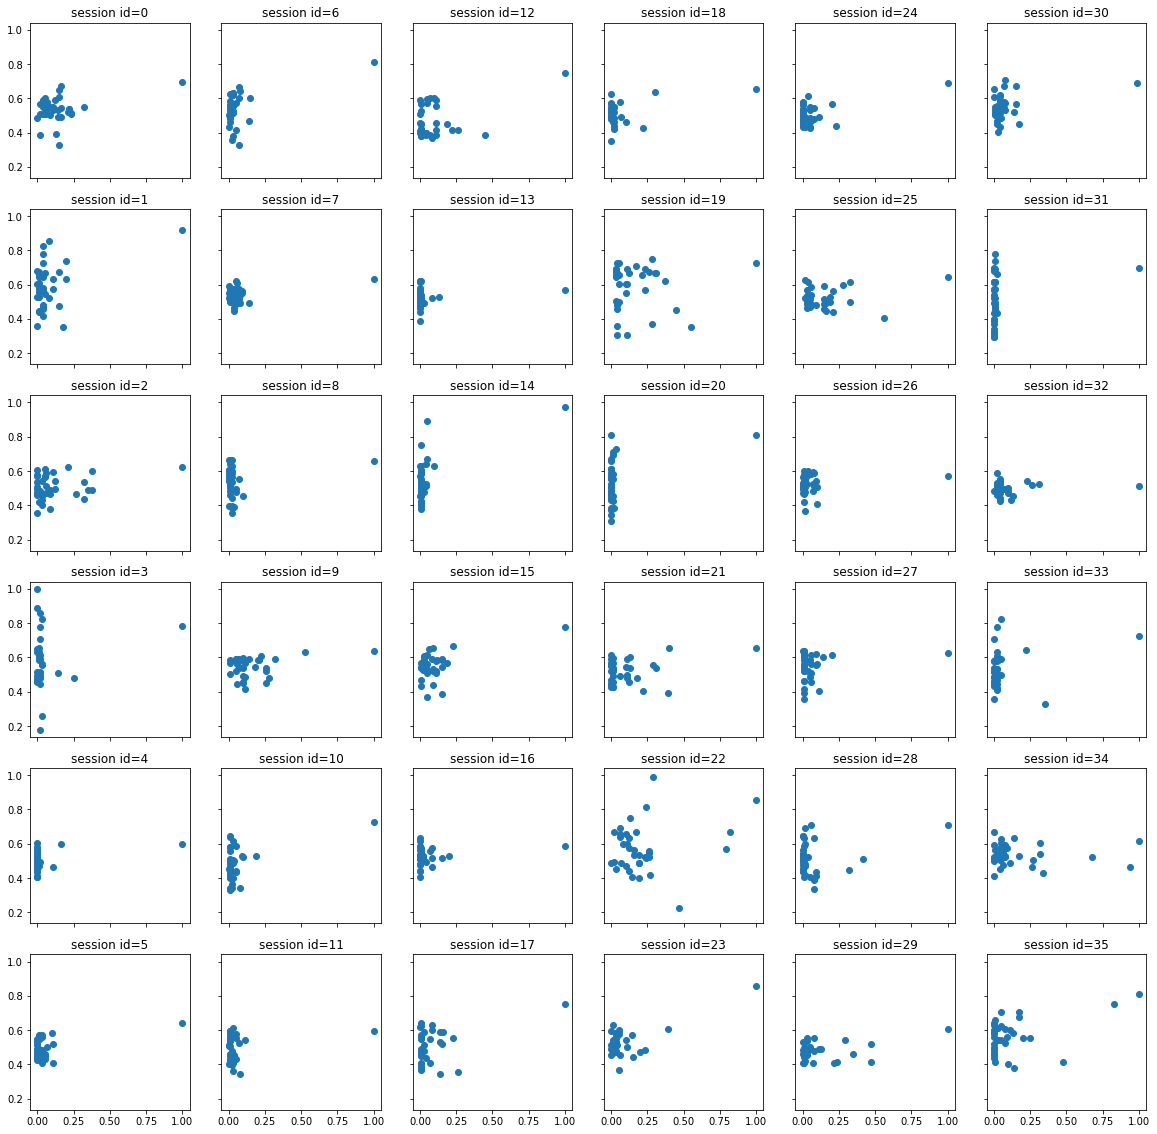

In [288]:
fig, ax = plt.subplots(6,6, figsize=(20,20), sharey=True, sharex=True)

p=0.8
for index in range(n_tasks):
    train_inds = tfld.even_sample_inds(y[index], p=p)
    scaler = tfld.TranslateStandardScale().fit(X[index][train_inds], y[index][train_inds])
    X_ = scaler.transform(X[index])

    fld = tfld.FLD().fit(X_[train_inds], y[index][train_inds])

    in_task_proj = fld.projection_
    dir_vectors = [in_task_proj] + [p for j,p in enumerate(projections) if j != index]
    
    bootstrap_vectors = bootstrap_projection_vectors(X_[train_inds], y[index][train_inds], 100, eps=0)
    
    mean_bootstrap=np.mean(bootstrap_vectors, axis=0)
    mean_bootstrap/=np.linalg.norm(mean_bootstrap)
    average_differences = get_pairwise_metric(bootstrap_vectors, abs_cosine_dist)
    
    test_statistics = np.array([ metric(mean_bootstrap, v) for v in dir_vectors])
    p_values = np.array([np.mean(t <= average_differences) for t in test_statistics])
    
    temp_fld_list = [fld] + [ fld_ for j,fld_ in enumerate(flds) if j != index]
    
    test = np.array([i for i in range(len(X_)) if i not in train_inds])
    accuracies = np.array([bas(fld_.predict(X_[test]), y[index][test]%2) for fld_ in temp_fld_list])
    
    ax[index % 6, index // 6].scatter(p_values, accuracies)

    
#     ax[index % 6, index // 6].hist(p_values)
    ax[index % 6, index // 6].set_title('session id=%i'%(index))

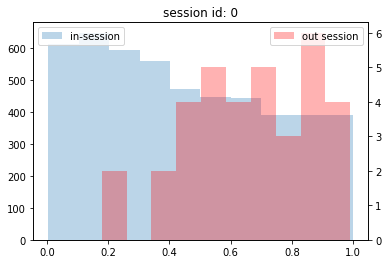

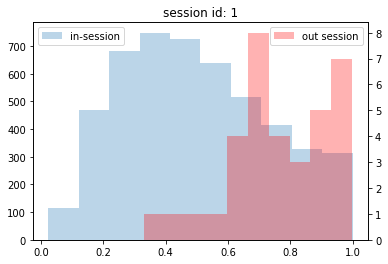

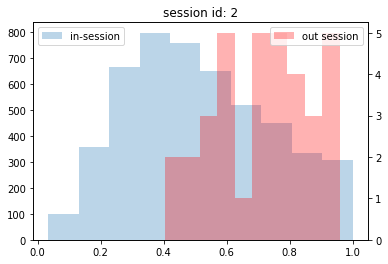

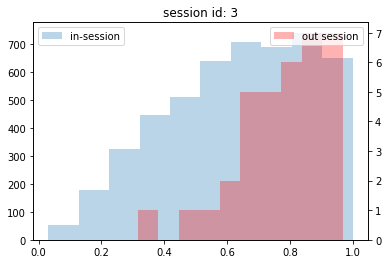

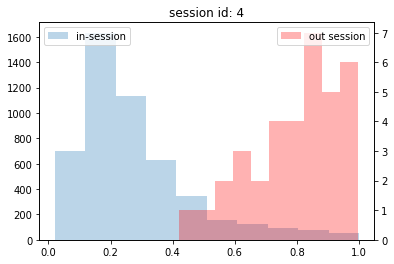

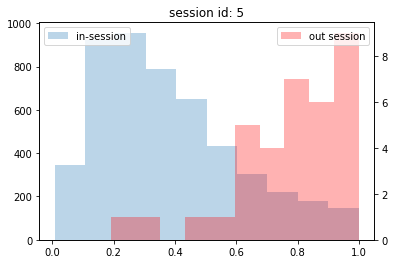

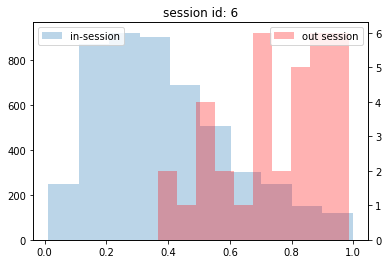

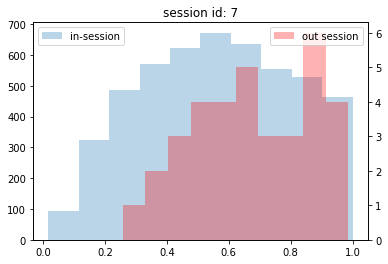

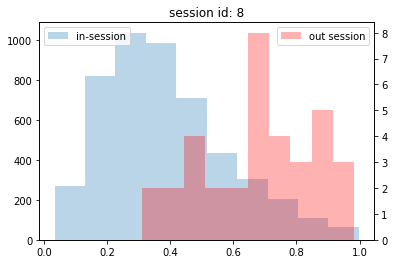

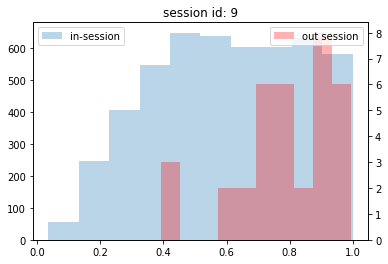

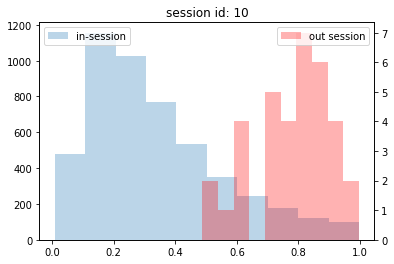

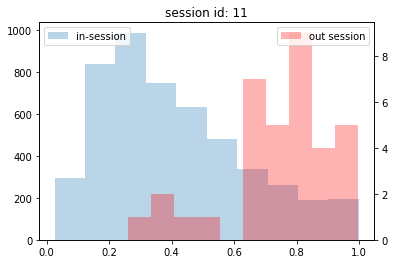

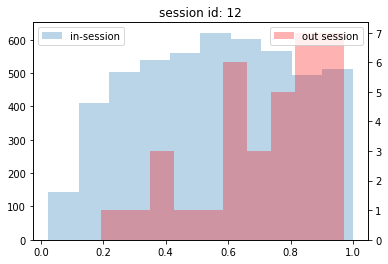

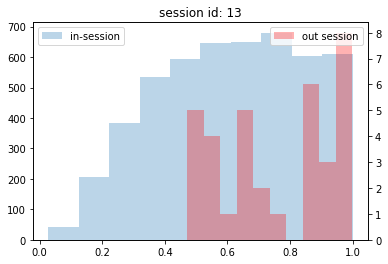

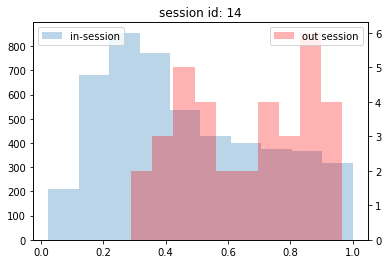

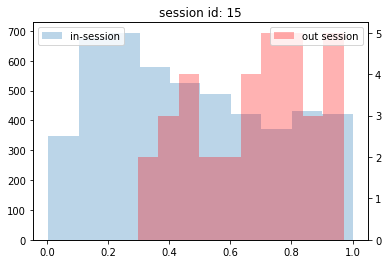

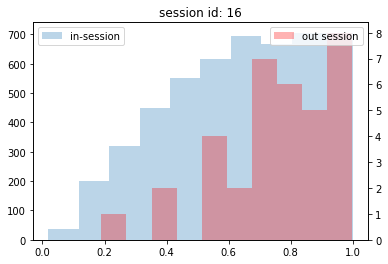

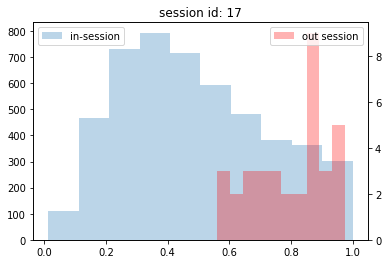

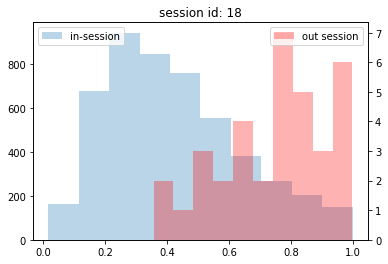

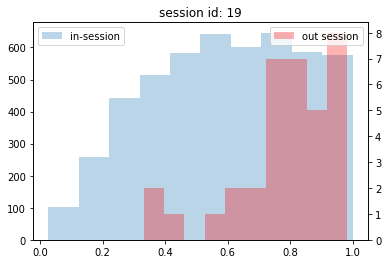

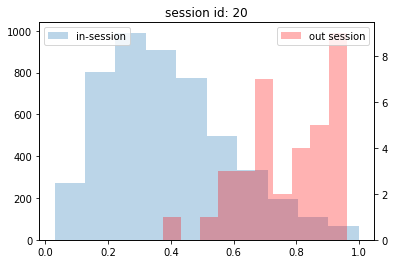

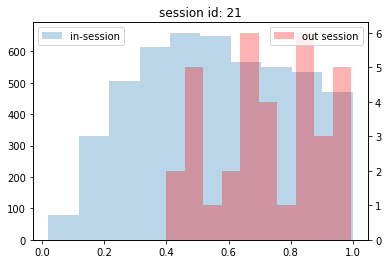

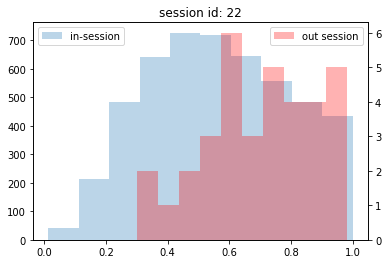

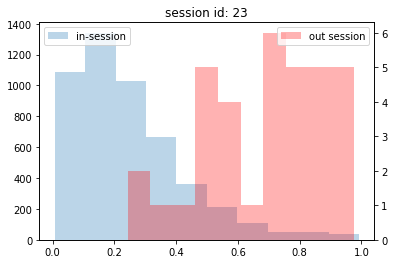

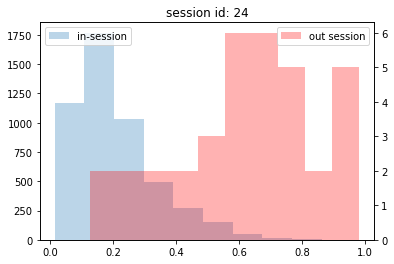

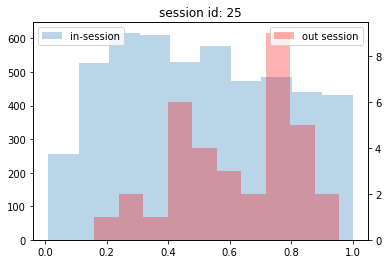

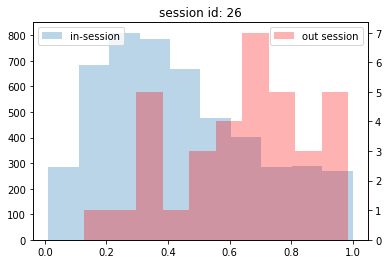

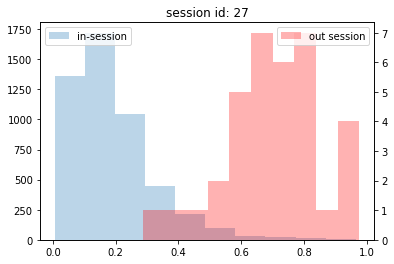

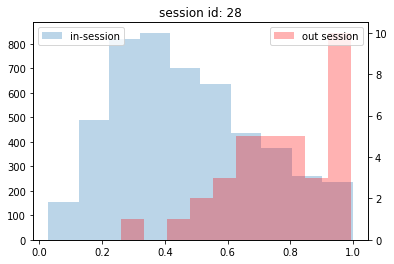

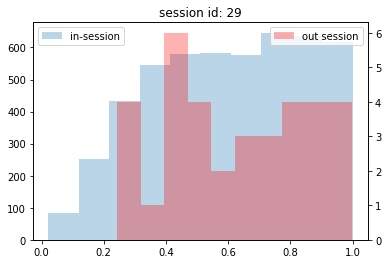

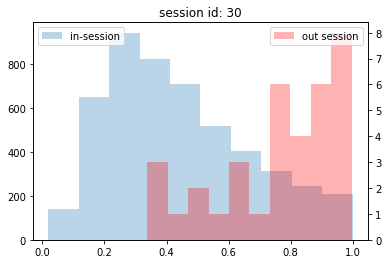

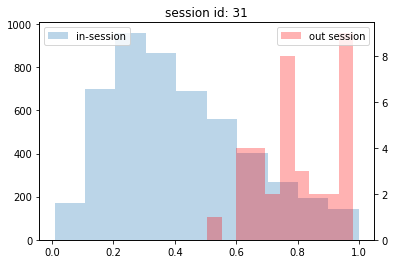

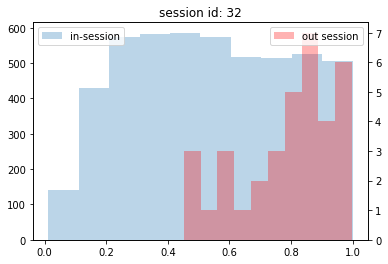

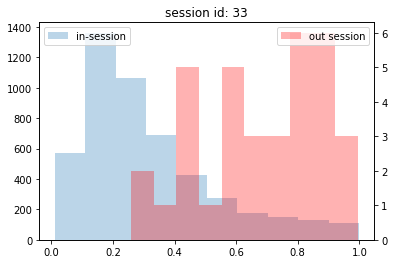

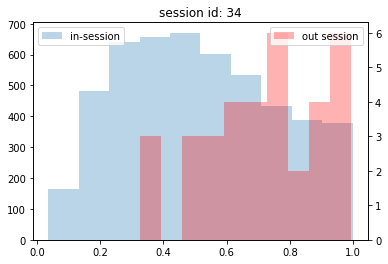

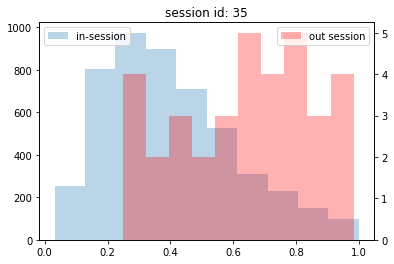

In [194]:
p=0.8

for index in range(n_tasks):
    train_inds = tfld.even_sample_inds(y[index], p=p)
    scaler = tfld.TranslateStandardScale().fit(X[index][train_inds], y[index][train_inds])
    X_ = scaler.transform(X[index])

    fld = tfld.FLD().fit(X_[train_inds], y[index][train_inds])

    in_task_proj = fld.projection_
    dir_vectors = [in_task_proj] + [p for j,p in enumerate(projections) if j != index]

    combined_proj = tfld.estimate_mu(dir_vectors)

    bootstrap_vectors = bootstrap_projection_vectors(X_[train_inds], y[index][train_inds]%2, 100, eps=0)

    nc2 = list(combinations(range(100), 2))
    cosine_dists = np.zeros(len(nc2))

    for i, c in enumerate(nc2):
        cosine_dists[i] = 1-abs(np.dot(bootstrap_vectors[c[0]], bootstrap_vectors[c[1]]))

    test_stat = [1 - abs(np.dot(dir_vectors[index], dir_vectors[j])) for j in range(n_tasks) if j != index]

    from scipy.stats import norm
    fig, ax = plt.subplots(1,1)

    ax.hist(cosine_dists, alpha=0.3, label='in-session')

    ax2 = ax.twinx()
    ax2.hist(test_stat, color='r', alpha=0.3, label='out session')
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')
    ax.set_title('session id: %i'%(index))

Text(0.5, 1.0, 'session id: 1')

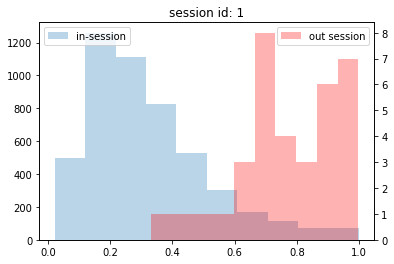

In [168]:
from sklearn.metrics import balanced_accuracy_score as bas
def optimal_alpha_experiment(X, y, p, grid=0.01, n_samples_to_estimate_risk=300, bootstrap_variance=False, remove_tasks=False, acorn=None):
    if acorn is not None:
        np.random.seed(acorn)
        
    assert len(X) == len(y)
    n_tasks = len(X)
    d  = len(X[0][0])
        
    # make target task projection vectors == [+/-1, 0_{d-1}]
    scalers = [tfld.TranslateStandardScale().fit(X[i], y[i]) for i in range(n_tasks)]
    
    I = np.eye(d)
        
    flds = [tfld.FLD(zero_intersection=True, cov=I).fit(scalers[i].transform(X[i]), y[i]) for i in range(n_tasks)]

    projections = [fld.projection_ for fld in flds]
    covs = [fld.cov for fld in flds]
    
    accuracies = np.zeros((n_tasks, 5))
    alphas = np.zeros((n_tasks, 2))
    for i in range(n_tasks):
        #- in task projection vector
        
        train_inds = tfld.even_sample_inds(y[i], p=p)
                
        scaler = tfld.TranslateStandardScale().fit(X[i][train_inds], y[i][train_inds])
        X_ = scaler.transform(X[i])
        
        fld = tfld.FLD(cov=I).fit(X_[train_inds], y[i][train_inds])
        
        in_task_proj = fld.projection_
        source_projs = [p for j,p in enumerate(projections) if j != i]
        combined_proj = tfld.estimate_mu(source_projs)
        
        bootstrap_vectors=tfld.bootstrap_scaler_and_projection(X[i][train_inds], y[i][train_inds], number_of_bootstraps=100)
        
        if bootstrap_variance:
            variance_from_target=tfld.get_cosine_variance(bootstrap_vectors)
        else:
            variance_from_target=None
            
        if remove_tasks:
            indices_to_keep = tfld.get_source_tasks_to_keep(bootstrap_vectors, source_projs, co)
            source_projs = np.array(source_projs)[indices_to_keep]
            
        #- optimal projection vector 
        if len(source_projs) == 0:
            optimal_alpha = 1
            optimal_proj = in_task_proj
        else: 
            optimal_alpha = tfld.get_optimal_alpha(len(train_inds), fld.means_[0], source_projs, 
                                                   grid, n_samples_to_estimate_risk=n_samples_to_estimate_risk, 
                                                   cov=I, variance_from_target=variance_from_target)
            optimal_proj = optimal_alpha * in_task_proj + (1 - optimal_alpha) * combined_proj
            optimal_proj /= np.linalg.norm(optimal_proj)
        
        alphas[i,0] = optimal_alpha
        
        #- oracle projection vector
        test = [j for j in range(len(X[i])) if j not in train_inds]
        
        if len(source_projs) == 0:
            oracle_alpha=1
            oracle_proj = in_task_proj
        else:
            oracle_alpha = utils.get_oracle_alpha(X[i][test], y[i][test], in_task_proj, combined_proj)

            oracle_proj = oracle_alpha * in_task_proj + (1 - oracle_alpha) * combined_proj
            oracle_proj /= np.linalg.norm(oracle_proj)
        
        alphas[i,1] = oracle_alpha
            
        
        #- Evaluation
        pred = (X[i][test] @ in_task_proj < 0).astype(int)
        accuracies[i, 0] = bas(y[i][test], pred)
        
        pred = (X[i][test] @ combined_proj < 0).astype(int)
        accuracies[i, 1] = bas(y[i][test], pred)
        
        pred = (X[i][test] @ optimal_proj < 0).astype(int)
        accuracies[i, 2] = bas(y[i][test], pred)
        
        pred = (X[i][test] @ oracle_proj < 0).astype(int)
        accuracies[i, 3] = bas(y[i][test], pred)
        
        random_accuracies = np.zeros(100)
        for j in range(100):
            random_alpha = np.random.choice(np.arange(0,1+grid, grid), size=1)[0]
            random_proj = random_alpha * in_task_proj + (1 - random_alpha) * combined_proj
            random_proj /= np.linalg.norm(random_proj)
            pred = (X[i][test] @ random_proj < 0).astype(int)
            random_accuracies[j] = bas(y[i][test], pred)
            
        accuracies[i, 4] = np.mean(random_accuracies)
        
#         print("optimal_alpha:", optimal_alpha, accuracies[i,2])
#         print("oracle_alpha:", oracle_alpha, accuracies[i,3])
#         print()
#     print(np.mean(accuracies, axis=0))
        
        
    return accuracies, alphas

In [169]:
np.random.seed(1)
from tqdm import tqdm

p_list = [0.2, 0.3, 0.5, 0.8]
n_mc=30

alpha_grid_size=0.01

n_jobs=30

n_samples_to_estimate_risk = 100

X_ = [x for i, x in enumerate(X) if learnable_indices[i]]
y_ = [y_ for i, y_ in enumerate(y) if learnable_indices[i]]

X_ = X
y_ = y

accuracies = np.zeros((len(p_list), n_mc, len(X_), 5))
alphas = np.zeros((len(p_list), n_mc, len(X_), 2))
for i, p in enumerate(tqdm(p_list)):
    f = lambda x: optimal_alpha_experiment(X_, y_, p, alpha_grid_size, n_samples_to_estimate_risk, bootstrap_variance=False, remove_tasks=False)
    
    results = Parallel(n_jobs=30)(delayed(f)(x) for x in np.zeros(n_mc))
    
    for j, (accuracy, alpha) in enumerate(results):
        accuracies[i,j] = accuracy
        alphas[i,j] = alpha
    
    print(i, np.mean(np.mean(accuracies, axis=1), axis=1)[i])

 25%|█████████████████████                                                               | 1/4 [02:24<07:14, 144.82s/it]

0 [0.65875213 0.5994004  0.65746314 0.68521213 0.63762769]


 50%|██████████████████████████████████████████                                          | 2/4 [04:49<04:49, 144.63s/it]

1 [0.66240175 0.59952952 0.65931658 0.68711064 0.63856801]


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [07:14<02:24, 144.89s/it]

2 [0.665994   0.5998858  0.66378349 0.69114351 0.64115138]


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [09:37<00:00, 144.45s/it]

3 [0.669375   0.59736691 0.66547027 0.69837705 0.64013045]


(array([2., 1., 5., 4., 3., 5., 2., 4., 5., 5.]),
 array([0.48964646, 0.52306818, 0.5564899 , 0.58991162, 0.62333333,
        0.65675505, 0.69017677, 0.72359848, 0.7570202 , 0.79044192,
        0.82386364]),
 <BarContainer object of 10 artists>)

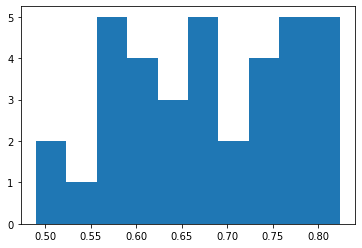

In [35]:
its = 30
p=0.8

accuracies = np.zeros((its, len(X)))

for i in range(its):
    for j in range(len(X)):
        train_inds = tfld.even_sample_inds(y[j], p=p)
        
        scaler = tfld.TranslateStandardScale().fit(X[j][train_inds], y[j][train_inds])
        X_ = scaler.transform(X[j])
        
        fld = tfld.FLD().fit(X_[train_inds], y[j][train_inds])
        test = [k for k in range(len(X[j])) if k not in train_inds]

        
        in_task_proj = fld.projection_
        
        pred = (X[j][test] @ in_task_proj < 0).astype(int)
        accuracies[i,j] = bas(y[j][test], pred)

mean_accuracies_full = np.mean(accuracies, axis=0)
learnable_indices = mean_accuracies_full >= 0.65
plt.hist(mean_accuracies_full)

(array([12., 10.,  6.,  3.,  1.,  1.,  2.,  0.,  0.,  0.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

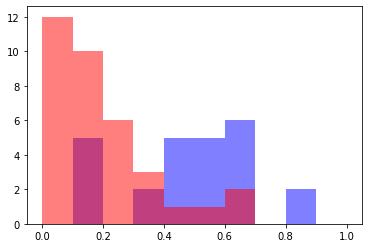

In [158]:
np.random.seed(0)
j = 3
n_tasks = len(X)
def get_cosine_variance(vectors):
    J, d = vectors.shape
    mu = tfld.estimate_mu(vectors)
    variance = np.mean([(1 - np.dot(mu, vec))**2 for vec in vectors], axis=0)
    return variance * np.eye(d)

p=0.1

train_inds = tfld.even_sample_inds(y[j], p=p)

bootstrap_vectors = bootstrap_everything(X[j][train_inds], y[j][train_inds])

scalers = [tfld.TranslateStandardScale().fit(X[i], y[i]) for i in range(n_tasks)]
flds = [tfld.FLD(zero_intersection=True).fit(scalers[i].transform(X[i]), y[i]) for i in range(n_tasks)]
projections = [fld.projection_ for fld in flds]
covs = [fld.cov for fld in flds]

mu_bootstrap = tfld.estimate_mu(bootstrap_vectors)
test_distances = np.array([abs(np.dot(mu_bootstrap, proj)) for proj in projections[1:]])
null_distribution = np.array([abs(np.dot(mu_bootstrap, bv)) for bv in bootstrap_vectors])

plt.hist(null_distribution, color='blue', bins=np.arange(0,1.1, step=0.1), alpha=0.5)
plt.hist(test_distances, color='red', bins=np.arange(0,1.1, step=0.1), alpha=0.5)




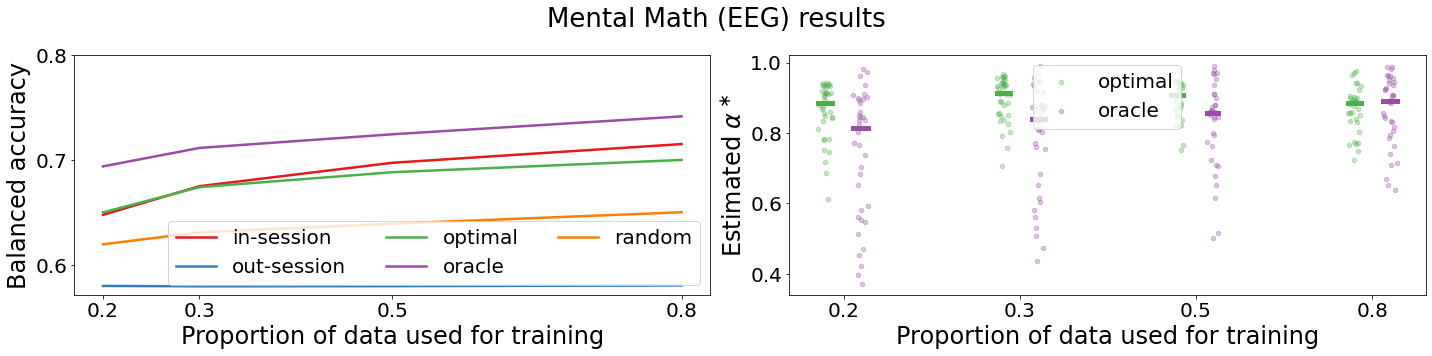

In [150]:
import seaborn as sns

mean_accuracies = np.mean(np.mean(accuracies, axis=1), axis=1)
std_accuracies = np.std(np.mean(accuracies, axis=1), axis=1) / np.sqrt((n_mc * len(X)))

mean_accuracies = mean_accuracies
p_list_ = np.array(p_list)

fig, ax = plt.subplots(1,2, figsize=(20,5))

algos = ['in-session', 'out-session', 'optimal', 'oracle', 'random']
colors = sns.color_palette("Set1", n_colors=len(algos))

fontsize=24
labelsize=20
for i, mean in enumerate(mean_accuracies.T):
    ax[0].plot(p_list_, mean, color=colors[i], label=algos[i], lw=2.5)
ax[0].legend(fontsize=20, loc='lower right', ncol=3)
# ax[0].set_title('Mental Math balanced accuracy', fontsize=18)

ax[0].set_ylabel('Balanced accuracy', fontsize=fontsize)
ax[0].set_xlabel('Proportion of data used for training', fontsize=fontsize)
ax[0].set_xticks(p_list_)
ax[0].tick_params(labelsize=labelsize)
ax[0].set_yticks([0.6, 0.7, 0.8])


mean_alphas = np.mean(alphas, axis=1)
for i, means in enumerate(mean_alphas):
    temp_norms = np.random.normal(i, 0.02, size=len(X_))
    
    optimals = means[:, 0]
    oracles = means[:, 1]
    
    if i == 0:
        ax[1].scatter(temp_norms - 0.1, optimals, s=20, alpha=0.33, color=colors[2], label='optimal')
        ax[1].scatter(temp_norms + 0.1, oracles, s=20, alpha=0.33, color=colors[3], label='oracle')
    else:
        ax[1].scatter(temp_norms - 0.1, optimals, s=20, alpha=0.33, color=colors[2])
        ax[1].scatter(temp_norms + 0.1, oracles, s=20, alpha=0.33, color=colors[3])
        

    ax[1].plot(np.sort(temp_norms) - 0.1, len(X_) * [np.median(optimals)], lw=5, color=colors[2])
    ax[1].plot(np.sort(temp_norms) + 0.1, len(X_) * [np.median(oracles)], lw=5, color=colors[3])
    

ax[1].legend(loc='upper center', fontsize=20)    
ax[1].set_ylabel(r'Estimated $\alpha^\ast$', fontsize=fontsize)
ax[1].set_xlabel('Proportion of data used for training', fontsize=fontsize)
ax[1].tick_params(labelsize=labelsize)
    
ax[1].set_xticks(np.arange(len(p_list_)), p_list_)

fig.suptitle('Mental Math (EEG) results', fontsize=fontsize+2)
plt.tight_layout()

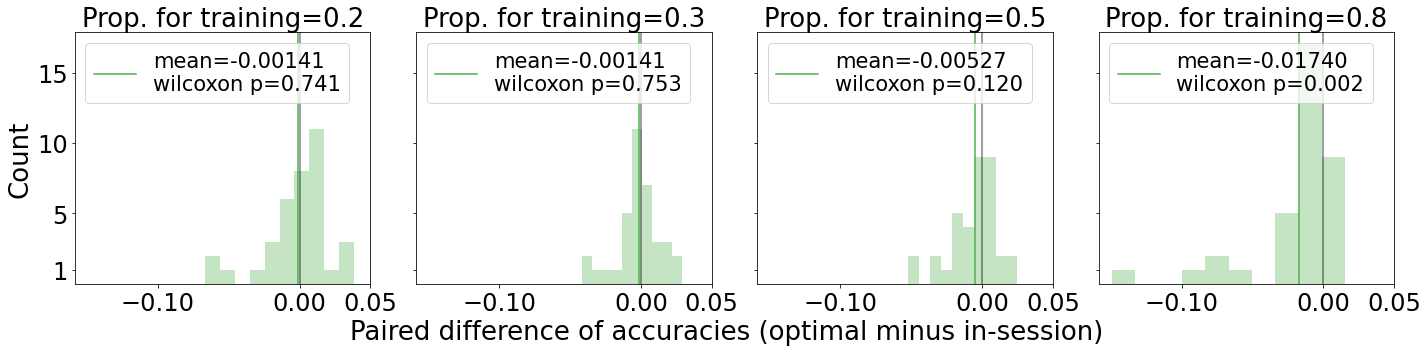

In [141]:
from scipy.stats import wilcoxon

fig, axes = plt.subplots(1, len(p_list_), figsize=(20,5), sharex=True, sharey=True)

optimal_minus_in_task = np.mean(accuracies, axis=1)[:,:, 2] - np.mean(accuracies, axis=1)[:, :, 0]

for i, ax in enumerate(axes):
    temp = optimal_minus_in_task[i]
    mean = np.mean(temp)
    T, p_ = wilcoxon(temp)
    
    ax.hist(temp, alpha=0.33, color=colors[2])
    ax.set_title('Prop. for training=%1.1f'%(p_list_[i]), fontsize=fontsize+2)
        
#     ax.tick_params(labelsize=16)
    ax.axvline(x=mean, label='mean=%1.5f\nwilcoxon p=%1.3f'%(mean, p_), color=colors[2])
    ax.axvline(x=0, c='k', alpha=0.5)
    
    ax.legend(fontsize=fontsize-3, loc='upper left')
    ax.tick_params(labelsize=fontsize)

    
axes[0].set_ylabel('Count', fontsize=fontsize+2)
axes[1].set_xlabel('Paired difference of accuracies (optimal minus in-session)', x=1.05, fontsize=fontsize+2)
axes[0].set_yticks([1, 5, 10, 15])

axes[0].set_xticks([-0.1, 0, 0.05])

# algos = ['in-task', 'out-task', 'optimal', 'oracle']
# colors = sns.color_palette("Set1", n_colors=len(algos))

# for i, mean in enumerate(mean_accuracies.T):
#     ax.plot(p_list[1:], mean[1:], color=colors[i], label=algos[i])
plt.tight_layout()
# plt.savefig('mental_math_histograms.pdf')